# **Word2Vec**
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 처리
2. CBOW, Skip-gram 모델 구현
3. 모델 학습을 통해 결과 확인
4. 산점도를 통해 단어 위치 확인

### **패키지 import**

In [1]:

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from tqdm import tqdm
from konlpy.tag import Mecab,Twitter,Okt,Kkma
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### **데이터 전처리**

데이터를 확인하고 Word2Vec 형식에 맞게 전처리

In [4]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

In [5]:
tokenizer = Okt()

In [6]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data):
    tokens = tokenizer.morphs(sent, stem=True)
    tokenized.append(tokens)

  return tokenized

In [7]:
train_tokenized = make_tokenized(train_data)

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [8]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 13349.15it/s]


In [9]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


In [10]:
w2i = {}
for pair in tqdm(word_count):
  if pair[0] not in w2i:
    w2i[pair[0]] = len(w2i)

i2w={v:k for k,v in w2i.items()}

100%|██████████| 60/60 [00:00<00:00, 412554.49it/s]


In [11]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

### Skipgram & CBoW

**Skipgram과 CBoW는 Word2Vec을 학습시키는 대표적인 방법이다.**
* CboW는 주변단어를 이용해, 주어진 단어를 예측하는 방법이다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법이다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있다.

참고자료 

* https://simonezz.tistory.com/35 

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314 



In [12]:
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          ############################ ANSWER HERE ################################
          # TODO 1: insert tokens for input self.x
          # TODO 2: insert tokens for targets self.y
          #########################################################################        
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.y.append(id)

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [13]:
class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = []

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
            ############################ ANSWER HERE ################################
          # TODO 1: insert tokens for input self.x
          # TODO 2: insert tokens for targets self.y
          #########################################################################        
          self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.x += [id] * 2 * window_size

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성

In [14]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

100%|██████████| 10/10 [00:00<00:00, 38944.33it/s]


[(tensor(0), tensor(17)), (tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(0)), (tensor(22), tensor(20)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(0)), (tensor(23), tensor(5)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tens

### **모델 Class 구현**

Word2Vec 모델을 구현


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [15]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [16]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim):
    super(SkipGram, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

모델 생성

In [17]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### **모델 학습**

hyperparamter를 세팅 & `DataLoader` 객체 생성

In [18]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

**CBOW 모델 학습**

In [19]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(cbow_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)
 
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

    print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 16/16 [00:01<00:00, 12.25it/s]


Train loss: 4.9373931884765625
Train loss: 5.422579765319824
Train loss: 4.819911479949951
Train loss: 4.342580318450928
Train loss: 4.748370170593262
Train loss: 4.9097490310668945
Train loss: 4.166576385498047
Train loss: 4.603665351867676
Train loss: 5.0394086837768555
Train loss: 4.928036689758301
Train loss: 4.0535383224487305
Train loss: 4.780143737792969
Train loss: 4.970691204071045
Train loss: 4.975743770599365
Train loss: 3.980632781982422
Train loss: 5.261016368865967
##################################################
Epoch: 2


100%|██████████| 16/16 [00:00<00:00, 445.56it/s]


Train loss: 4.778326034545898
Train loss: 5.2637939453125
Train loss: 4.693275451660156
Train loss: 4.215664863586426
Train loss: 4.621594429016113
Train loss: 4.647703170776367
Train loss: 4.018379211425781
Train loss: 4.473371505737305
Train loss: 4.929274559020996
Train loss: 4.774653434753418
Train loss: 3.9147887229919434
Train loss: 4.456131458282471
Train loss: 4.8171796798706055
Train loss: 4.839935302734375
Train loss: 3.860090732574463
Train loss: 5.150390625
##################################################
Epoch: 3


100%|██████████| 16/16 [00:00<00:00, 238.72it/s]


Train loss: 4.623929500579834
Train loss: 5.106991767883301
Train loss: 4.567992210388184
Train loss: 4.090644836425781
Train loss: 4.496175765991211
Train loss: 4.394819259643555
Train loss: 3.8750672340393066
Train loss: 4.345240116119385
Train loss: 4.821857452392578
Train loss: 4.6243181228637695
Train loss: 3.7834725379943848
Train loss: 4.145127296447754
Train loss: 4.6661577224731445
Train loss: 4.708703994750977
Train loss: 3.7432618141174316
Train loss: 5.040447235107422
##################################################
Epoch: 4


100%|██████████| 16/16 [00:00<00:00, 220.20it/s]


Train loss: 4.473906517028809
Train loss: 4.952216148376465
Train loss: 4.444087982177734
Train loss: 3.9675211906433105
Train loss: 4.372121810913086
Train loss: 4.152706146240234
Train loss: 3.7364866733551025
Train loss: 4.2192277908325195
Train loss: 4.717226982116699
Train loss: 4.477323055267334
Train loss: 3.660407066345215
Train loss: 3.8499064445495605
Train loss: 4.517634868621826
Train loss: 4.581523418426514
Train loss: 3.6298911571502686
Train loss: 4.931231498718262
##################################################
Epoch: 5


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 4.327986240386963
Train loss: 4.799521446228027
Train loss: 4.321592330932617
Train loss: 3.846310615539551
Train loss: 4.249454498291016


100%|██████████| 16/16 [00:00<00:00, 240.07it/s]

Train loss: 3.922760486602783
Train loss: 3.6024954319000244
Train loss: 4.0953049659729
Train loss: 4.615401744842529
Train loss: 4.33392333984375
Train loss: 3.546266794204712
Train loss: 3.573124408721924
Train loss: 4.371638298034668
Train loss: 4.457970142364502
Train loss: 3.519747257232666
Train loss: 4.822809219360352
Finished.


**Skip-gram**

In [20]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(skipgram_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = skipgram(x)  # (B, V)

    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 64/64 [00:00<00:00, 494.70it/s]


Train loss: 3.8631348609924316
##################################################
Epoch: 2


100%|██████████| 64/64 [00:00<00:00, 720.76it/s]


Train loss: 3.8157174587249756
##################################################
Epoch: 3


100%|██████████| 64/64 [00:00<00:00, 738.81it/s]


Train loss: 3.7689669132232666
##################################################
Epoch: 4


100%|██████████| 64/64 [00:00<00:00, 751.28it/s]


Train loss: 3.722897529602051
##################################################
Epoch: 5


100%|██████████| 64/64 [00:00<00:00, 468.68it/s]

Train loss: 3.6775238513946533
Finished.


### **Test**

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인

In [21]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(emb.squeeze(0))

Word: 음식
tensor([ 3.8819e-01,  4.5597e-01,  1.8482e-01,  6.9573e-01,  1.7826e+00,
         4.5139e-01,  1.5733e-01, -2.0915e+00, -7.3943e-01,  2.9290e-02,
        -3.8213e-01,  1.5126e-01,  3.1830e-01, -9.9633e-01,  3.1693e-02,
         1.6093e+00,  1.8536e-01,  2.9994e-02, -1.3545e+00, -9.3895e-02,
         5.9492e-01,  1.2876e-01,  3.4406e+00,  1.2330e-01,  1.0149e+00,
        -2.1975e+00,  1.2547e+00,  1.6103e-02, -4.8165e-01,  1.6793e-01,
        -1.2659e+00, -5.2297e-01,  4.2143e-02, -1.9258e+00,  9.2901e-01,
        -6.8105e-01, -9.1022e-01,  7.6903e-01,  6.2057e-01, -1.1266e+00,
        -9.3735e-01,  1.7363e+00,  2.3226e-01,  1.1572e+00,  4.8925e-01,
         3.5952e-01,  1.4324e+00, -6.5610e-02,  3.1693e+00, -4.1978e-02,
        -6.6331e-01,  2.6757e+00,  1.0738e-01, -6.7103e-01, -5.1573e-01,
        -1.1150e+00, -8.2511e-01,  1.1475e+00, -7.4904e-01, -9.9866e-01,
        -2.9908e-01, -1.1839e+00,  1.8238e+00, -4.7608e-01, -4.9512e-01,
        -1.0902e+00,  1.8425e+00, -6.9518e

In [22]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0)))

Word: 음식
tensor(2.6466, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 맛
tensor(2.4156, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(3.4326, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 위생
tensor(3.4236, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 가격
tensor(3.1082, device='cuda:0', grad_fn=<UnbindBackward0>)


In [23]:
test_words

['음식', '맛', '서비스', '위생', '가격']

In [24]:
i2w[25]

'다시'

In [25]:
def most_similar(word,top_k=5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score=torch.matmul(input_emb,skipgram.embedding.weight.transpose(1,0)).view(-1)

  _,top_k_ids=torch.topk(score,top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:]

In [26]:
most_similar("가격")

['이다', '에', '만족스럽다', '맛']

## Word2Vec 시각화

In [27]:
from sklearn.decomposition import PCA

In [28]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='NanumBarunGothic') 
#plt.rc('font', family='AppleGothic') #맥

In [29]:
pca=PCA(n_components=2)

In [30]:
pc_weight=pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


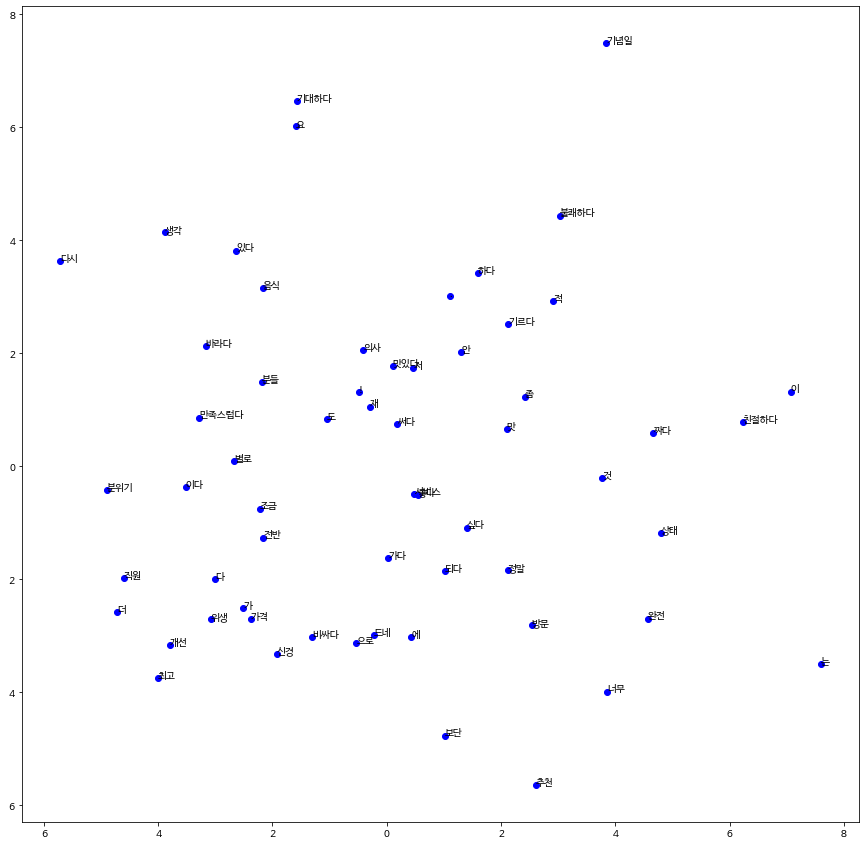

In [31]:
plt.figure(figsize=(15,15))

for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate, y_coordinate))